In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import os

from util.train_model import ModelTrainer
from util.function import *

from model.gru_base import GRUModel

In [2]:
set_seed(0)

Set random seed as 0 for pytorch


# 1.数据加载

## 1.1参数设置

In [3]:
train_start_date = '2012-01-01'
train_end_date =   '2016-12-31'
test_start_date =  '2017-01-01'
test_end_date =    '2017-12-31'
test_final_date = '2024-06-30'
seq_len = 40 
step = 5
batch_size = 5000

## 1.2数据预处理

In [4]:
def RawData_Preprocess(df,
                       drop_ratio: float = (2/3),
                       ret_muti_index: bool = True,
                       label_is_normal: bool = True):
    # 先按法则去除部分行
    # 未缺失比例少于2/3的行进行剔除，再剔除 y 缺失的行，剩下的特征 nan 值用0值填充
    df = df.dropna(thresh=(df.shape[1]-1)*drop_ratio,axis = 0)
    df = df.dropna(subset=['return'])
    df = df.fillna(0)
    df = df.reset_index()
    # 标签is_normal处理
    if label_is_normal:
        df['return'] = df.groupby('datetime')['return'].apply(lambda x: (x-x.mean())/x.std() if x.std() != 0 else (x-x.mean()))
    # 是否返回双重index的df格式
    if ret_muti_index:
        df.set_index(['datetime','stock_code'],inplace=True)
    return df

In [5]:
raw_data = pd.read_parquet(
    '/home/chenglei/higgs_quant/fin_con_ML_factor/data/factors/df_factor_20d_return_120101_240831.par')
raw_data = RawData_Preprocess(raw_data,
                              drop_ratio=(2/3),
                              ret_muti_index=False,
                              label_is_normal=True)


In [6]:
raw_data

,datetime,stock_code,con_np_yoy_rank_0_neg,con_npgrate_13w_n1_neg,con_peg_0_neg,con_na_0_neg,con_eps_0_neg,con_pe_n1_neg,con_np_0_neg,con_or_yoy_rank_0_neg,...,qfa_deductedprofittoprofit_day,currentdebttodebt_day_no_neu_ind,roic_day,qfa_ocftosales_day,con_pb_n1_20d_pctchange_neg,con_peg_n1_40d_pctchange_div_degree_40d_mean,con_peg_rank_n1_40d_quantile_neg,con_eps_rank_n1_40d_quantile_neg,con_pb_roe_rank_0_60d_quantile_diff,return
0,2012-01-04,000001.SZ,-1.596669,0.051041,0.219036,0.171563,-2.017405,0.469378,0.211076,-1.579931,...,0.000000,0.000000,0.000000,0.017521,-0.863446,-0.254357,0.490604,0.144228,0.386844,0.448241
1,2012-01-04,000002.SZ,-0.372734,-0.049687,0.178856,-8.439709,-1.406188,-0.032110,-8.637513,-0.935532,...,0.000000,0.181095,-0.387832,0.043341,-1.291807,-0.162367,-1.466329,0.482868,-2.167505,-0.348073
2,2012-01-04,000004.SZ,1.208983,1.397304,-10.586397,0.705467,1.166688,-2.834055,0.738565,1.611798,...,0.000000,0.784411,-0.624007,0.079640,0.814592,-0.081248,-0.103655,-0.024616,-0.359889,0.158970
3,2012-01-04,000005.SZ,1.262926,-0.045737,0.166415,0.431885,0.973001,-0.255797,0.413711,1.321765,...,0.000000,0.855715,0.000000,0.126558,-1.178618,-0.162367,-0.832495,0.535393,-1.339208,-0.704240
4,2012-01-04,000006.SZ,-0.075310,-0.073843,0.175828,0.030088,-0.523711,-0.027530,-0.076780,0.086311,...,0.000000,0.313045,0.660729,0.123769,0.044352,-0.162367,0.994439,1.060643,1.711350,0.557088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10731731,2024-08-02,688799.SH,-0.822800,0.006269,0.218363,0.378478,-1.618167,0.047904,0.161343,-0.839119,...,-0.031771,-0.014603,0.170969,0.046452,0.464277,-0.107827,0.386046,1.285088,0.897780,0.179199
10731732,2024-08-02,688800.SH,-0.940738,0.040583,0.213413,0.229518,-0.652248,-0.034975,0.117155,-1.034376,...,0.086909,0.076870,0.429833,-0.228300,0.543321,-0.045397,1.200306,0.250248,-0.087408,-0.829634
10731733,2024-08-02,688819.SH,-0.175887,0.003244,0.301439,-0.695456,-1.267282,0.078486,-0.625492,-0.186072,...,-0.522410,0.381793,0.665846,0.397990,0.479354,-0.044991,-0.138982,-0.868426,0.928502,1.557766
10731734,2024-08-02,688981.SH,0.041221,0.037566,-0.440526,-9.245888,0.157797,-0.067087,-2.225524,0.490785,...,0.152710,-1.668502,-0.272305,0.565055,-0.104935,-0.037627,0.278158,0.711772,0.493368,0.231607


# 2.滚动模型

## 2.1模型设置

In [7]:
try_label = 'gru_rolling_mse_10_24_factor30_v1_y_normal'

## 2.2滚动函数

In [8]:
def gru_model_rolling(df,
                      train_start_date: str,
                      train_end_date: str,
                      test_start_date: str,
                      test_end_date: str,
                      test_final_date: str,
                      jump: int,
                      times: int,
                      train_period_years: int,
                      batch_size: int,
                      try_label: str,
                      sep_len: int,
                      step: int):
    """输入数据和模型，以及滚动训练的时间和规则设置，完成滚动训练

    Args:
        df (DataFrame): 全数据
        train_start_date (str): 训练集开始日期
        train_end_date (str): 训练集结束日期
        test_start_date (str): 测试集开始日期
        test_end_date (str): 测试集结束日期
        test_final_date (str): 测试集最终日期，如果测试集结束日期超过测试集最终日期，则被职位测试集最终日期
        jump (int): 相邻滚动的年数间隔，如为 1 则，每次滚动数据往后推迟一年
        times (int): 滚动训练的总次数
        train_period_years: 训练集年数，如果按照规律滚动时训练集年数少于给定值，则会固定训练集开始年份不变，直至训练集年数达到给定值
        batch_size: 训练单个批次的大小
        try_label: 此次模型的标记
        sep_len: 单个样本的时间步数
        step: 采样间隔

    Returns:
        _type_: 所有滚动训练合并的预测值（pivotal 格式），损失 loss
    """
    dict_date = {'train_start_date': train_start_date,
                 'train_end_date': train_end_date,
                 'test_start_date': test_start_date,
                 'test_end_date': test_end_date}

    y_pred_list = []
    loss_list = []
    for k in tqdm(range(times),desc="outer", colour='red'):

        # 计算当次训练的训练日期和测试日期
        list_date_temp = [pd.to_datetime(
            s)+pd.DateOffset(years=jump if k > 0 else 0) for s in list(dict_date.values())]

        from dateutil.relativedelta import relativedelta
        if relativedelta(list_date_temp[2], list_date_temp[0]).years < train_period_years:
            list_date_temp[0] = pd.to_datetime(dict_date['train_start_date'])

        if list_date_temp[-1] > pd.to_datetime(test_final_date):
            list_date_temp[-1] = pd.to_datetime(test_final_date)

        list_date_temp = [date.strftime('%Y-%m-%d') for date in list_date_temp]
        dict_date_temp = dict(zip(dict_date.keys(), list_date_temp))

        # 获取训练测试数据,特征已做标准化
        x1_train, x1_valid, X_test, y_train, y_valid, y_test, train_date, test_date, sample_stock = gru_dataloader(df=df,
                                                                                                                   **dict_date_temp,
                                                                                                                   seq_len=seq_len,
                                                                                                                   step=step)
        train_ds = Newdataset(x1_train, y_train)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

        valid_ds = Newdataset(x1_valid, y_valid)
        valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

        # 训练标签
        try_label_current = try_label + '_' + \
            dict_date_temp['train_start_date'] + \
            '_' + dict_date_temp['train_end_date']
        model = GRUModel(input_num=30,
                         hidden_num=60)

        # 模型设置和训练
        optimizer = optim.Adam(model.parameters(), lr=0.005)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        modeltrainer = ModelTrainer(
            model, optimizer, device, name=try_label_current)
        train_ic_list, val_ic_list = modeltrainer.fit_rolling(
            train_dl, valid_dl, 'data',loss_fun='mse')

        # 加载存储的最佳模型
        model = torch.load(f'data/saved_model/{try_label_current}.pt')
        modeltrainer = ModelTrainer(
            model, optimizer, device, name=try_label_current)

        # 预测
        y_pred = predict_test_set(X_test=X_test,
                                  y_test=y_test,
                                  modeltrainer=modeltrainer,
                                  test_date=test_date,
                                  sample_stock=sample_stock,
                                  seq_len=seq_len)
        y_pred_list.append(y_pred)

        # loss计算
        loss = round(max(val_ic_list), 4)
        loss_list.append(loss)

        # 更新日期字典
        dict_date = dict_date_temp

    # 合并所有滚动的预测结果
    y_pred = pd.concat(y_pred_list)
    # 计算平均误差
    loss = np.mean(loss_list)

    return y_pred, loss


## 2.3训练&预测

100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2012-01-01_2016-12-31
Set random seed as 0 for pytorch


100%|██████████| 30/30 [00:44<00:00,  1.48s/it]s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2012-01-01_2017-12-31
Set random seed as 0 for pytorch


100%|██████████| 30/30 [00:47<00:00,  1.60s/it]4s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2012-01-01_2018-12-31
Set random seed as 0 for pytorch


100%|██████████| 30/30 [00:58<00:00,  1.94s/it]8s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2012-01-01_2019-12-31
Set random seed as 0 for pytorch


100%|██████████| 30/30 [00:58<00:00,  1.96s/it]6s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2013-01-01_2020-12-31
Set random seed as 0 for pytorch


100%|██████████| 30/30 [01:01<00:00,  2.05s/it]3s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2014-01-01_2021-12-31
Set random seed as 0 for pytorch


100%|██████████| 30/30 [01:12<00:00,  2.40s/it]1s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2015-01-01_2022-12-31
Set random seed as 0 for pytorch


100%|██████████| 30/30 [01:09<00:00,  2.31s/it]6s/it]


gru_rolling_mse_10_24_factor30_v1_y_normal_2016-01-01_2023-12-31
Set random seed as 0 for pytorch


outer: 100%|██████████| 8/8 [28:07<00:00, 210.89s/it]


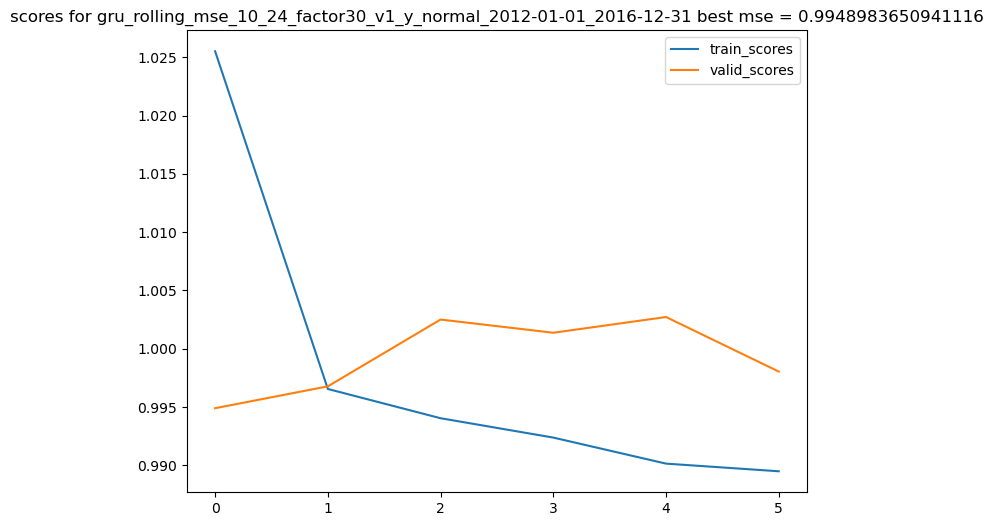

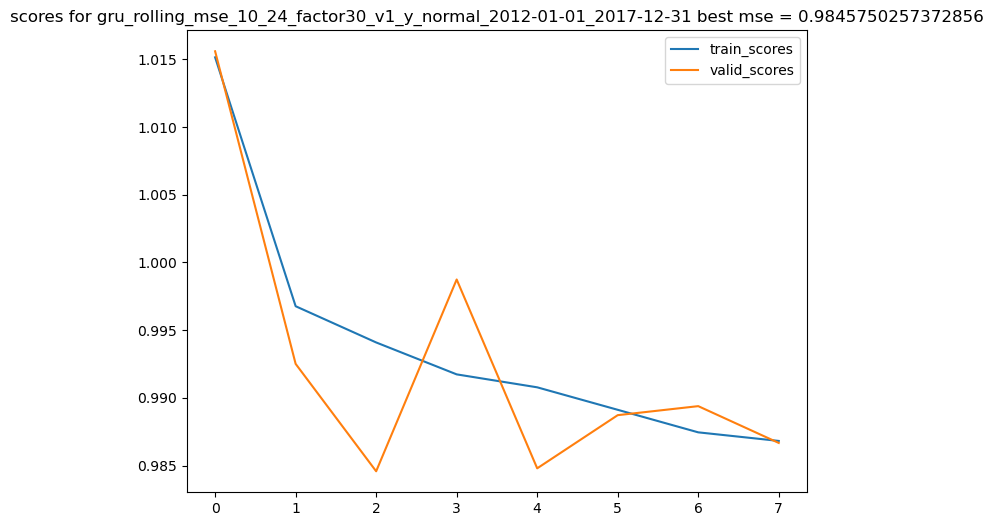

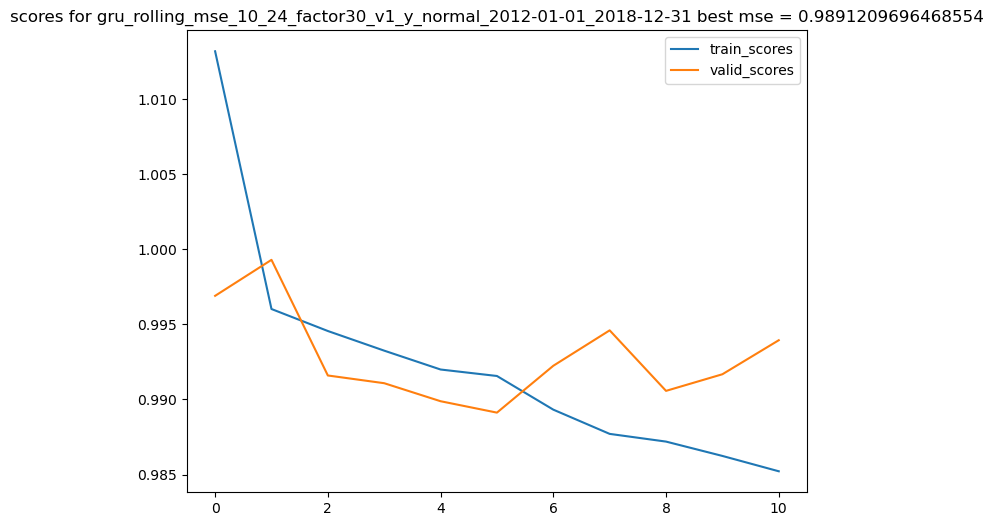

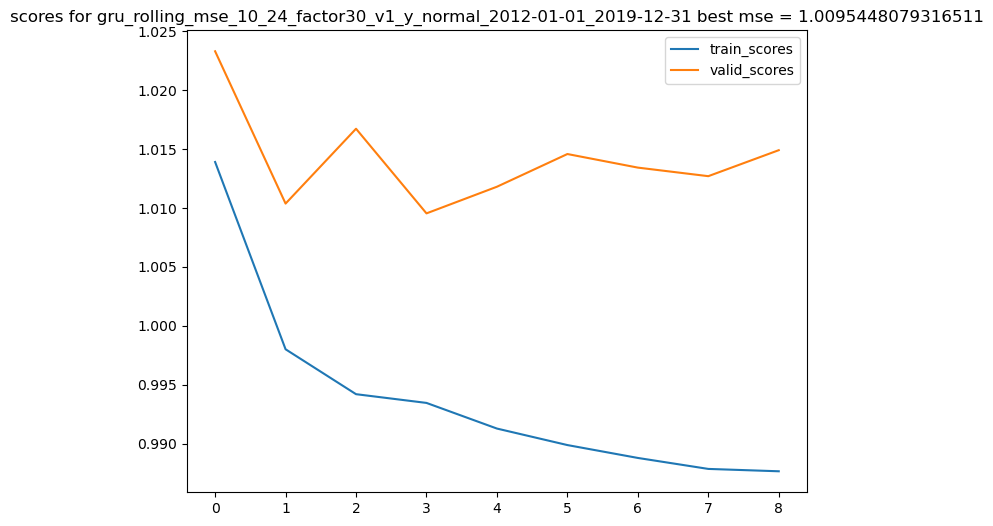

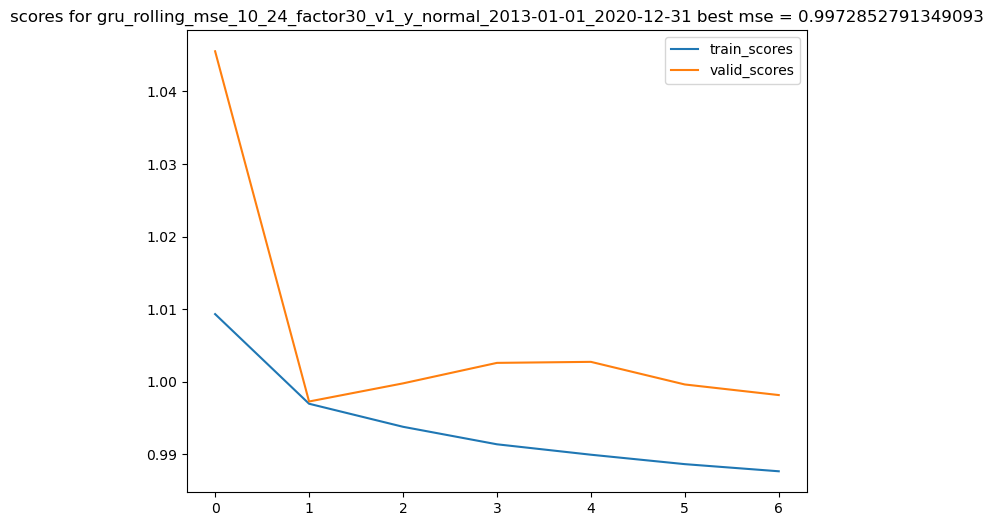

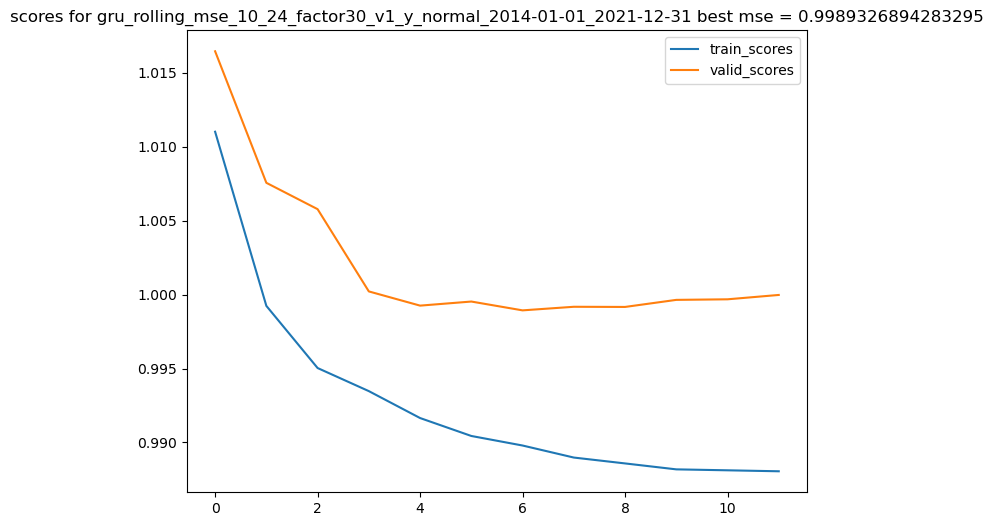

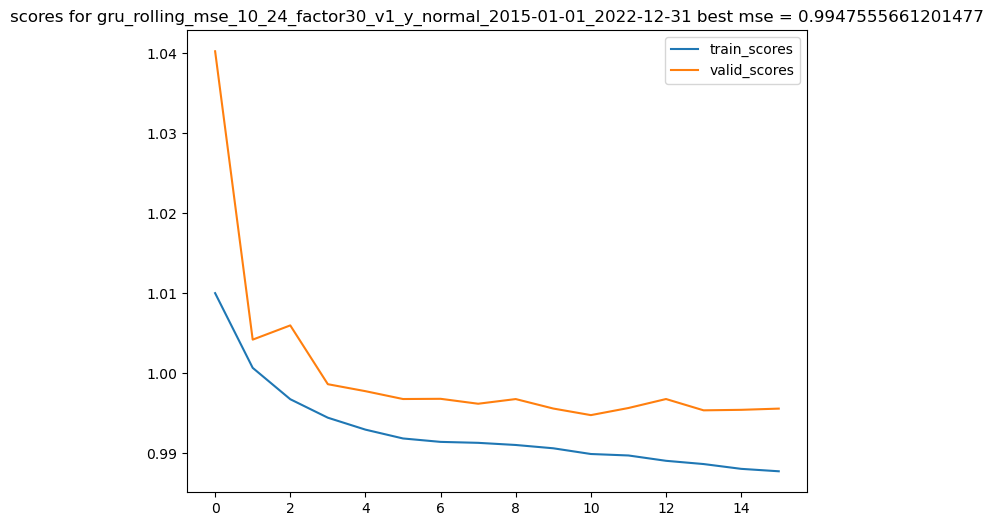

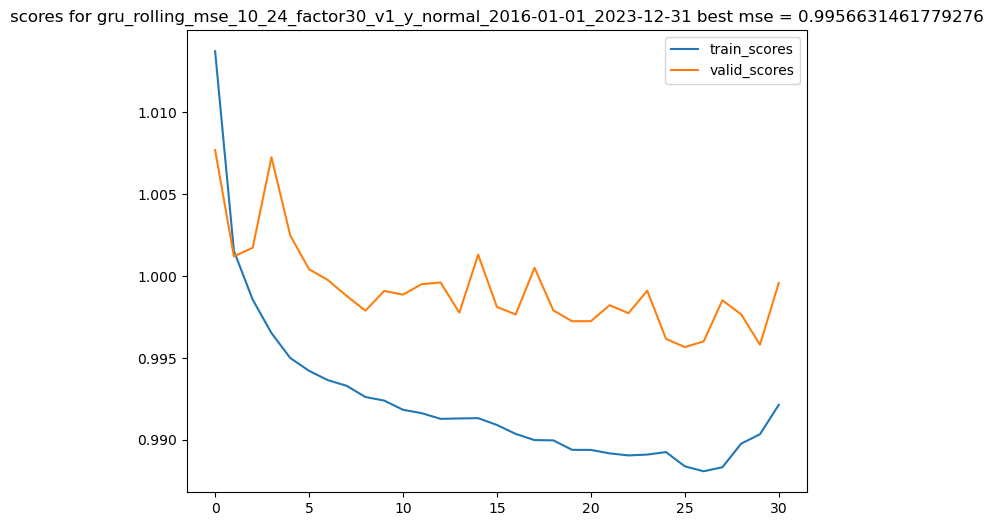

In [9]:
df_y_pred, loss = gru_model_rolling(df=raw_data,
                                    train_start_date=train_start_date,
                                    train_end_date=train_end_date,
                                    test_start_date=test_start_date,
                                    test_end_date=test_end_date,
                                    test_final_date=test_final_date,
                                    jump=1,
                                    times=8,
                                    train_period_years=8,
                                    batch_size=batch_size,
                                    try_label=try_label,
                                    sep_len=seq_len,
                                    step=step)


In [10]:
loss

1.01885

In [11]:
df_y_pred

stock_code,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,688671.SH,688691.SH,688693.SH,688695.SH,688702.SH,688709.SH,688716.SH,688717.SH,688719.SH,688720.SH
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.265700,-0.180124,0.115738,0.035314,-0.204096,-0.021863,-0.128286,-0.075051,0.073573,-0.182875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.259352,-0.179006,0.120504,0.021713,-0.211347,-0.024283,-0.095674,-0.051454,0.067840,-0.236488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,0.271239,-0.182441,0.106262,-0.012653,-0.198252,-0.018641,-0.111659,-0.052293,0.080118,-0.231906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,0.260250,-0.185561,0.104530,0.010205,-0.159196,-0.011917,-0.070665,-0.085952,0.072623,-0.221242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,0.241966,-0.181492,0.095438,-0.026446,-0.173352,-0.000320,-0.097395,-0.085857,0.067579,-0.297688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,0.053858,-0.028378,-0.102825,NaN,-0.003298,-0.126793,0.099819,-0.021008,-0.184698,-0.147793,...,NaN,-0.227140,-0.335728,NaN,NaN,-0.086951,NaN,-0.218346,NaN,NaN
2024-06-25,0.028486,-0.020762,-0.104788,NaN,-0.068012,-0.115127,0.095116,-0.027933,-0.240783,-0.126682,...,NaN,-0.267674,-0.332315,NaN,0.070004,-0.059625,NaN,-0.201147,NaN,NaN
2024-06-26,0.038528,0.015900,-0.086510,NaN,-0.058758,-0.074048,0.085842,-0.021298,-0.268238,-0.083858,...,NaN,-0.213693,-0.325416,NaN,-0.021498,-0.085700,-0.239313,-0.183678,NaN,NaN


# 4.回测

## 4.1回测1d

[1430118:MainThread](2024-10-24 16:21:00,786) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:55] - Initialization
[1430118:MainThread](2024-10-24 16:21:00,893) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:98] - Use old y, start prepare_y


return_future is aquired
RankIC is calculated


[1430118:MainThread](2024-10-24 16:21:40,089) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:394] - pic has been saved in /home/chenglei/higgs_quant/back_test_results/group_test_results/gru_rolling_mse_10_24_factor30_v1_y_normal_y_pred_17_24.png


gru_rolling_mse_10_24_factor30_v1_y_normal_y_pred_17_24


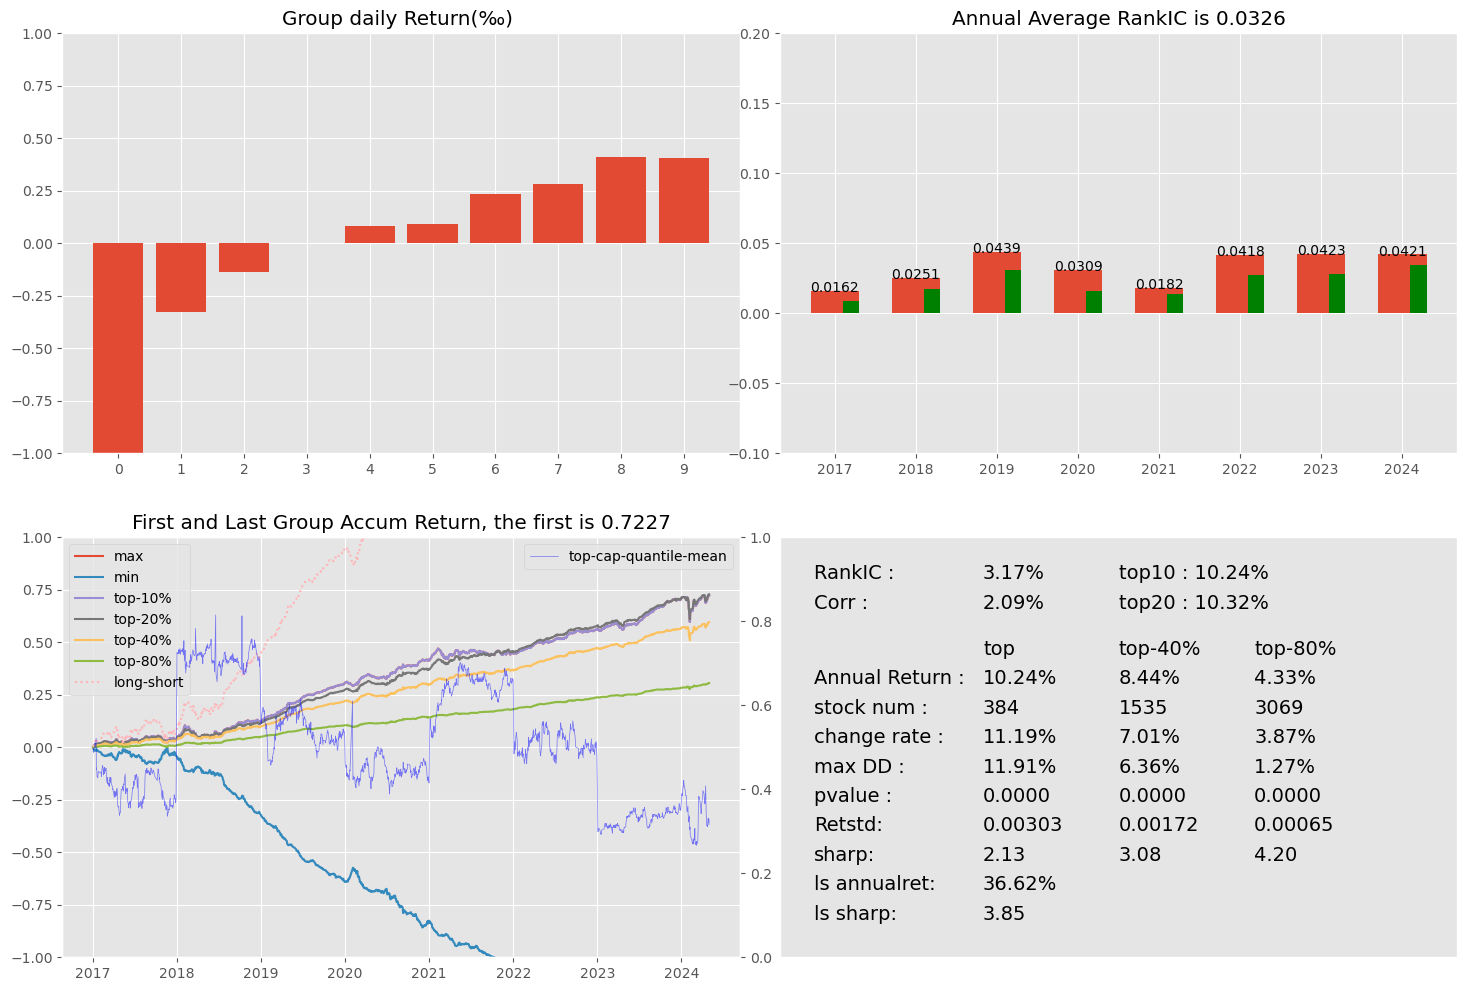

strategy_test func time_cost -> 39.76581406593323


In [12]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/home/chenglei/higgs_quant')

from AlphaSim.AlphaSim_hf import AlphaBacktestHF
OUTPUT_BASEDIR =  "/home/chenglei/higgs_quant/back_test_results/"

class BaseConfig():
    alpha_name = 'default'
    money = 20000000
    output_basedir = OUTPUT_BASEDIR
    # const_dir =  "/mnt/weka/home/gubingchuan/data_gubc/home/gubingchuan/const"
    const_dir = "/mnt/weka/home/chenglei/higgs_quant/const"
    init_y = False
    # ==================== buy_price 和 sell_price============================
    # 可选close, twap, twap_f2hh, twap_f4hh, twap_56hh, twap_34hh, twap_l4hh
    buy_price = "twap"
    sell_price = "twap"
    period = 1 #调仓周期改为一天
    # =====================基准===============================================
    # 可选"HS300", "ZZ500", "Ashare", null,
    benchmark = "Ashare" # 注意，这里的Ashare 指股票池内股票简单平均
    # =====================是否考虑交易限制====================================
    # 可选'lock', 'remove', 'free', 分别代表：
    # lock：锁住涨跌停的仓位
    # remove：涨跌停的股票置为0
    # free：不考虑涨跌停限制
    trade_constrain = 'remove'
    # =====================时间===============================================
    start_date = "2014-01-01"
    end_date = "2024-06-30"
    # ======================对alpha的处理=====================================
    # 强制市场中性
    is_market_neutral = True
    # 市值分层中性 # 暂时没用
    is_cap_neutral = False # 暂时没用
    # 行业中性,目前行业数据更新到 202400630
    is_industry_neutral = False
    # 选取部分行业回测，空列表[]默认为所有行业，行业标准参考申万 1 级
    is_part_industry = []
    # ======================是否做分组测试=====================================
    is_group_test = False
    
Backtest = AlphaBacktestHF(BaseConfig)
result = Backtest.strategy_test(
    df_y_pred,
    ngrp=10,
    name=f'{try_label}_y_pred_17_24')


## 4.2回测20d

[1430118:MainThread](2024-10-24 16:31:43,566) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:55] - Initialization
[1430118:MainThread](2024-10-24 16:31:43,644) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:98] - Use old y, start prepare_y


return_future is aquired
RankIC is calculated


[1430118:MainThread](2024-10-24 16:32:22,502) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:394] - pic has been saved in /home/chenglei/higgs_quant/back_test_results/group_test_results/gru_rolling_mse_10_24_factor30_v1_y_normal_y_pred_17_24.png


gru_rolling_mse_10_24_factor30_v1_y_normal_y_pred_17_24


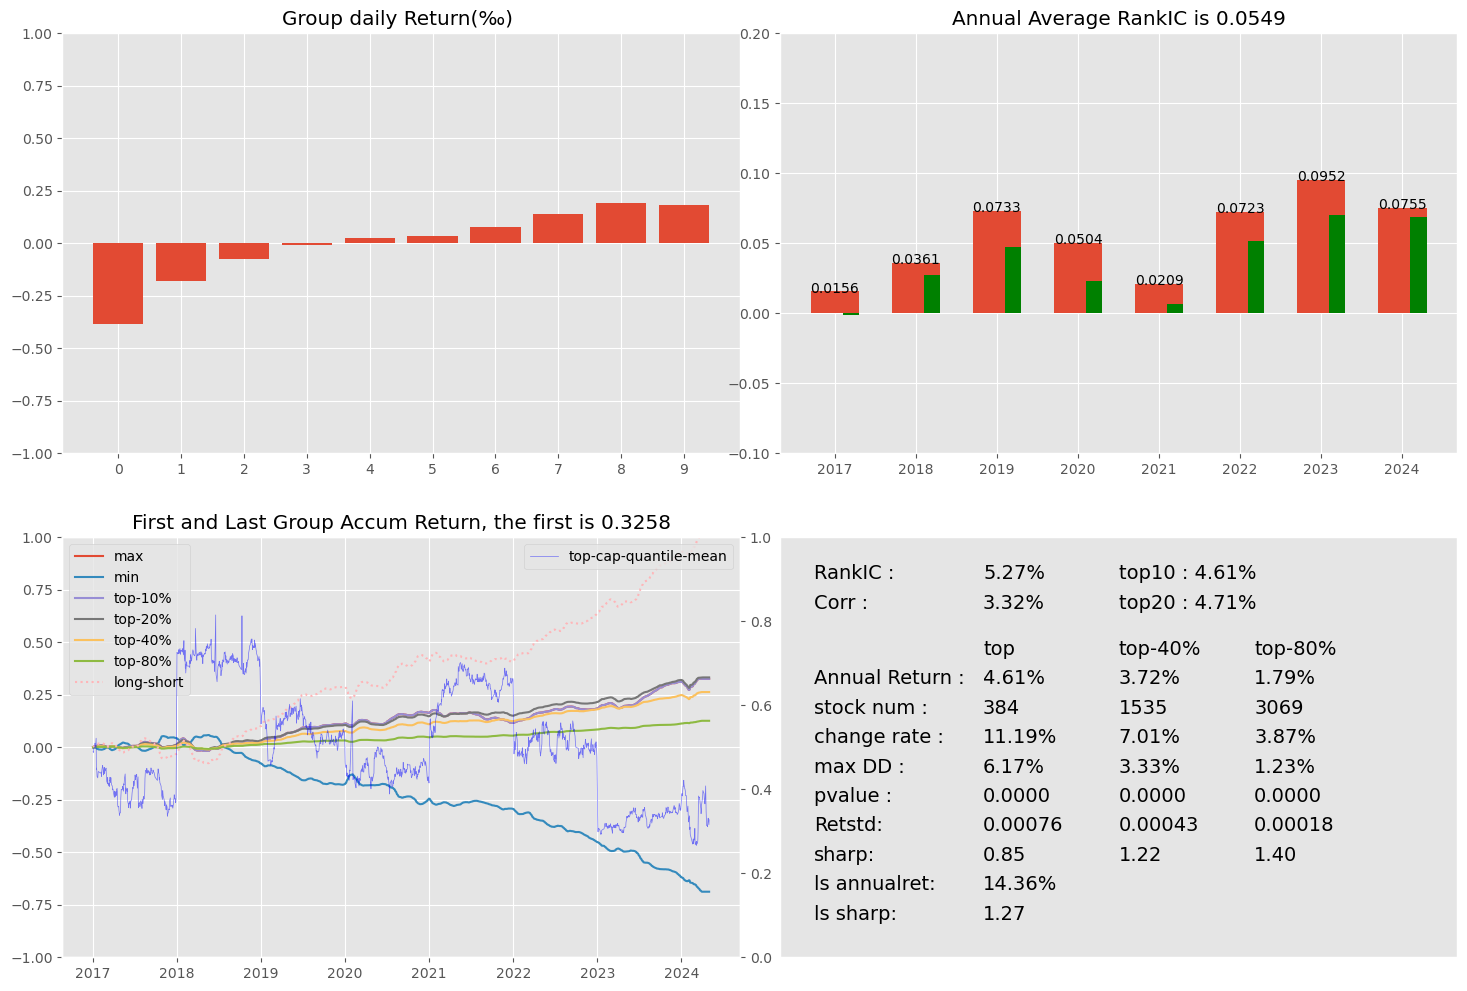

strategy_test func time_cost -> 39.344056606292725


In [13]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/home/chenglei/higgs_quant')

from AlphaSim.AlphaSim_hf import AlphaBacktestHF
OUTPUT_BASEDIR =  "/home/chenglei/higgs_quant/back_test_results/"

class BaseConfig():
    alpha_name = 'default'
    money = 20000000
    output_basedir = OUTPUT_BASEDIR
    # const_dir =  "/mnt/weka/home/gubingchuan/data_gubc/home/gubingchuan/const"
    const_dir = "/mnt/weka/home/chenglei/higgs_quant/const"
    init_y = False
    # ==================== buy_price 和 sell_price============================
    # 可选close, twap, twap_f2hh, twap_f4hh, twap_56hh, twap_34hh, twap_l4hh
    buy_price = "twap"
    sell_price = "twap"
    period = 20 #调仓周期
    # =====================基准===============================================
    # 可选"HS300", "ZZ500", "Ashare", null,
    benchmark = "Ashare" # 注意，这里的Ashare 指股票池内股票简单平均
    # =====================是否考虑交易限制====================================
    # 可选'lock', 'remove', 'free', 分别代表：
    # lock：锁住涨跌停的仓位
    # remove：涨跌停的股票置为0
    # free：不考虑涨跌停限制
    trade_constrain = 'remove'
    # =====================时间===============================================
    start_date = "2014-01-01"
    end_date = "2024-06-30"
    # ======================对alpha的处理=====================================
    # 强制市场中性
    is_market_neutral = True
    # 市值分层中性 # 暂时没用
    is_cap_neutral = False # 暂时没用
    # 行业中性,目前行业数据更新到 202400630
    is_industry_neutral = False
    # 选取部分行业回测，空列表[]默认为所有行业，行业标准参考申万 1 级
    is_part_industry = []
    # ======================是否做分组测试=====================================
    is_group_test = False
    
Backtest = AlphaBacktestHF(BaseConfig)
result = Backtest.strategy_test(
    df_y_pred,
    ngrp=10,
    name=f'{try_label}_y_pred_17_24')
